In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate, interpolate
import casadi as ca

In [3]:
%matplotlib inline

## Yanking from
https://github.com/CardiacModelling/FourWaysOfFitting/blob/main/model-and-protocols/beattie-2017-ikr-hh.mmt

In [4]:
volt_ts, volts = np.genfromtxt("./protocol-staircaseramp.csv", skip_header=1, dtype=float, delimiter=',').T

In [5]:
volt_fn = interpolate.interp1d(volt_ts, volts, kind='previous')
volt_ca = ca.interpolant('volts', 'linear', [volt_ts], volts)

In [6]:
def V_np(t):
#     return -80 + ca.floor(t/1000) * 20 + ca.mod(ca.floor(t/500), 2) * -10
    return volt_fn(t/1000)

In [7]:
def V_ca(t):
    return volt_ca(t/1000)

In [8]:
V = V_np

In [9]:
# V = -80 #mV
EK = -88.4 #mV

def ion_model(t, y, p):
    a, r = y[:2]
    *ps, g = p[:9]
    k1 = p[0]*ca.exp(p[1]*V(t))
    k2 = p[2]*ca.exp(-p[3]*V(t))
    k3 = p[4]*ca.exp(p[5]*V(t))
    k4 = p[6]*ca.exp(-p[7]*V(t))
    
    a_inf = k1/(k1+k2)
    tau_a = 1/(k1+k2)
    r_inf = k4/(k3+k4)
    tau_r = 1/(k3+k4)
    
    
    da = (a_inf - a)/tau_a
    dr = (r_inf - r)/tau_r
    
    return [
        da, 
        dr
    ]

In [10]:
def obsv(t, y, p):
    # I
    a, r = y[:2]
    *ps, g = p[:9]
    return g * a * r * (V(t) - EK)

In [11]:
y0 = [ # a, r
    0, 1]

p_true = [2.26e-4, 0.0699, 3.45e-5, 0.05462, 0.0873, 8.91e-3, 5.15e-3, 0.03158, 0.1524]

In [12]:
tlim = [0, 15_000]
ts = np.linspace(*tlim, tlim[-1])

In [13]:
ar_sol = integrate.solve_ivp(ion_model, tlim, y0, args=[p_true], dense_output=True)

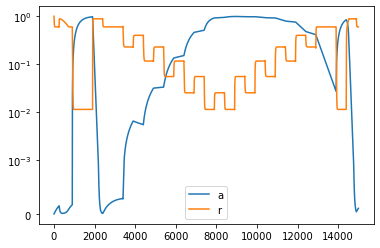

In [14]:
plt.figure()
plt.plot(ts, ar_sol.sol(ts).T, label=['a', 'r'])
plt.yscale('symlog', linthresh=1e-3)
# for yi in ar_sol.t:
#     plt.axvline(yi, color='k', lw=0.1)
plt.legend()

In [15]:
ar_sol_a, ar_sol_r = ar_sol.sol(ts)

In [16]:
ar_O = ar_sol_a*ar_sol_r
ar_I = ar_sol_a*(1-ar_sol_r)
ar_C = (1-ar_sol_a)*ar_sol_r
ar_IC = (1-ar_sol_a)*(1-ar_sol_r)
ar_stack = np.vstack([ar_O, ar_I, ar_C, ar_IC])


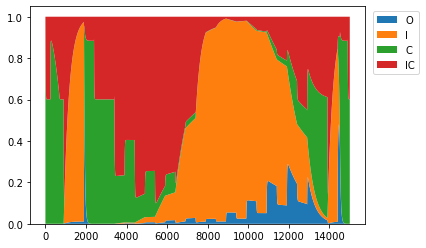

In [17]:
plt.figure()
plt.stackplot(ts, ar_stack, labels=['O', 'I', 'C', 'IC'])
plt.legend(bbox_to_anchor=[1.01, 1], loc='upper left')

Text(0.5, 0, 't (ms)')

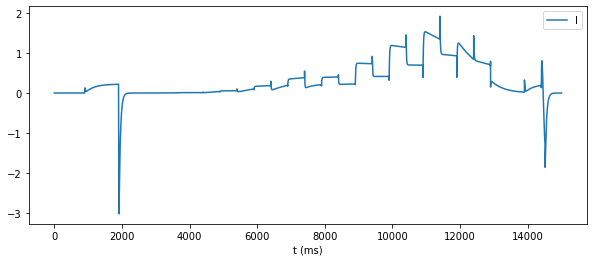

In [18]:
plt.figure(figsize=[10, 4])
plt.plot(ts, obsv(ts, ar_sol.sol(ts), p_true))
plt.legend('I')
plt.xlabel('t (ms)')

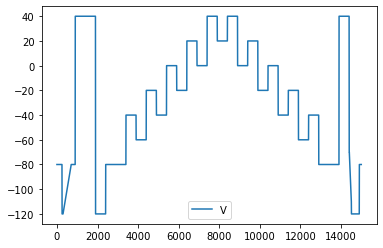

In [19]:
plt.figure()
plt.plot(ts, V(ts))
plt.legend('V')

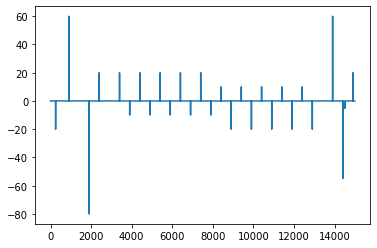

In [20]:
plt.figure()
plt.plot(ts, np.gradient(V(ts), ts))

## Testing casadi compat with V(t)

In [21]:
import pypei

In [30]:
import process_volts_again as pva
from importlib import reload

reload(pva)

<module 'process_volts_again' from 'C:\\Users\\dwu\\REPOS\\ionch\\process_volts_again.py'>

In [31]:
n_grid = 400

In [38]:
pf400 = pva.expanded_fn(n_grid)

# pre discretise V
def V_discr(t):
    return pf400(np.linspace(*tlim, n_grid)/1000).T


def VX(t):
    return pf400(t/1000)

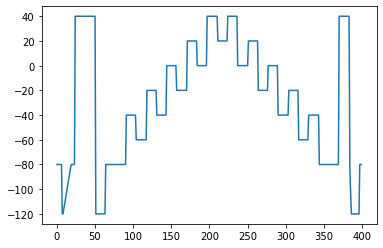

In [39]:
plt.plot(V_discr(None))

note here that the restriction on V being prediscretised means 
that the observational points must necessarily be a strict subset of 
the collocation points.

In [49]:
V = V_discr

In [51]:
mdl_config = {
    'grid_size': n_grid,
    'basis_number': 40,
    'model': ion_model,
    'model_form': {
        'state': 2,
        'parameters': 9,
    },
    'time_span': tlim,
    'know_function': None,
    'dataset': None,
}

splmdl = pypei.modeller.Model(configuration=mdl_config)

In [47]:
problem = pypei.Problem()

In [52]:
problem.build_model(
    model_fn=ion_model,
    model_form = {
        'state': 2,
        'parameters': 9,
    },
    time_span=tlim,
    grid_size=n_grid,
)

In [68]:
def obsv_ca(t, y, p):
    a, r = ca.horzsplit(y, 1)
    *p_, g = p
    return g * a * r * (V(t) - EK)
    

In [90]:
interpolant = obsv_ca(problem.model.observation_times, problem.model.all_x_at(problem.model.cs, problem.model.observation_times), problem.model.ps)

In [101]:
# generate synthetic data
truth_synth = obsv(problem.model.observation_times, ar_sol.sol(problem.model.observation_times), p_true)

y_synth = (truth_synth * (1 + 0.05*np.random.randn(*truth_synth.shape))).toarray()

In [84]:
%matplotlib notebook

<IPython.core.display.Javascript object>


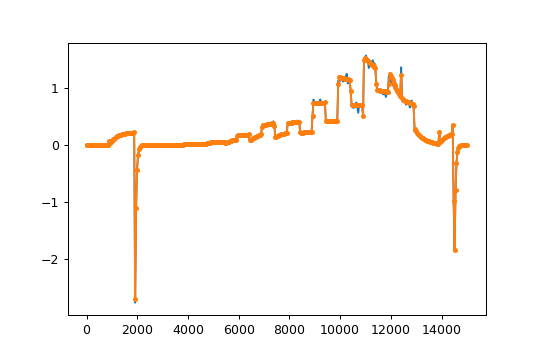

In [120]:
plt.figure()
plt.plot(problem.model.observation_times, y_synth)
plt.plot(problem.model.observation_times, truth_synth, marker='.')

# plt.ylim(-1, 2)

In [103]:
# manually build data objects
problem.data_time = problem.model.observation_times
problem.data_orig = y_synth
problem.data = y_synth

problem.interpolator = interpolant

In [104]:
model_struct = {
    'order':'I',
    'inherent_order': 'I',
}

problem.build_objective(model_struct, balance=False)

In [126]:
problem.build_solver(constraint_opts={'ubg': 1}, guess_opts={'x0': 0.5})

In [127]:
sln = problem.solve()

Iteration: 0
This is Ipopt version 3.14.8, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3116
Number of nonzeros in Lagrangian Hessian.............:      827

Total number of variables............................:       89
                     variables with only lower bounds:        9
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4446437e+25 0.00e+00 3.47e+19  -1.0 0.00e+00    -  0.00e+

 200  1.8806440e+02 0.00e+00 2.85e+00  -5.7 2.87e-03    -  1.00e+00 5.00e-01f  2 
 250  1.8802039e+02 0.00e+00 2.20e+00  -5.7 2.05e-03    -  1.00e+00 1.00e+00h  1 
 300  1.8799816e+02 0.00e+00 2.91e-01  -5.7 4.44e-04    -  1.00e+00 1.00e+00h  1 


CasADi - 2022-09-28 11:05:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [D:\bld\casadi_1657871534063\work\casadi\core\oracle_function.cpp:265]
CasADi - 2022-09-28 11:05:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [D:\bld\casadi_1657871534063\work\casadi\core\oracle_function.cpp:265]
CasADi - 2022-09-28 11:05:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [D:\bld\casadi_1657871534063\work\casadi\core\oracle_function.cpp:265]
CasADi - 2022-09-28 11:05:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [D:\bld\casadi_1657871534063\work\casadi\core\oracle_function.cpp:265]
CasADi - 2022-09-28 11:05:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [D:\bld\casadi_1657871534063\work\casadi\core\oracle_function.cpp:265]
CasADi - 2022-09-28 11:05:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [D:

 350  1.8782788e+02 0.00e+00 2.97e+00  -8.6 2.44e-03    -  1.00e+00 1.00e+00f  1 
 400  1.8781084e+02 0.00e+00 1.58e+00  -8.6 1.87e-03    -  1.00e+00 1.00e+00h  1 
 450  1.8779436e+02 0.00e+00 1.43e+00  -8.6 3.21e-03    -  1.00e+00 5.00e-01h  2 
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.8777710e+02 0.00e+00 1.17e+00  -8.6 1.91e-03    -  1.00e+00 1.00e+00f  1 
 550  1.8775223e+02 0.00e+00 9.42e-01  -8.6 2.54e-03    -  1.00e+00 1.00e+00f  1 
 600  1.8766107e+02 0.00e+00 1.16e+00  -8.6 2.16e-03    -  1.00e+00 1.00e+00f  1 
 650  1.8756305e+02 0.00e+00 5.67e-01  -8.6 1.51e-02    -  1.00e+00 1.00e+00f  1 
 700  1.8746312e+02 0.00e+00 6.91e-01  -8.6 1.77e-03    -  1.00e+00 1.00e+00f  1 
 750  1.8738629e+02 0.00e+00 5.94e-01  -8.6 1.27e-03    -  1.00e+00 1.00e+00f  1 
 800  1.8733236e+02 0.00e+00 1.05e+00  -8.6 1.40e-03    -  1.00e+00 1.00e+00f  1 
 850  1.8729762e+02 0.00e+00 7.16e-01  -8.6 1.11e-03    -  1.00e+00 1.00e+00f  1 
 900  1.8727511e+

 500  1.0512845e+03 0.00e+00 2.12e+02  -3.8 9.53e-03    -  1.00e+00 5.00e-01f  2 
 550  1.0247407e+03 0.00e+00 5.30e+01  -3.8 6.45e-03    -  1.00e+00 2.50e-01f  3 
 600  1.0117657e+03 0.00e+00 1.41e+01  -3.8 8.53e-04    -  1.00e+00 1.00e+00f  1 
 650  1.0059933e+03 0.00e+00 1.67e+01  -3.8 1.22e-03    -  1.00e+00 1.00e+00f  1 
 700  1.0035208e+03 0.00e+00 5.19e+00  -3.8 4.88e-04    -  1.00e+00 5.00e-01h  2 
 750  3.6273348e+02 0.00e+00 6.18e+00  -5.7 3.65e-02    -  1.00e+00 1.00e+00f  1 
 800  3.2460287e+02 0.00e+00 6.00e+01  -5.7 6.35e-04    -  1.00e+00 1.00e+00f  1 
 850  3.2372915e+02 0.00e+00 6.80e+00  -5.7 1.95e-04    -  1.00e+00 1.00e+00f  1 
 900  3.2304361e+02 0.00e+00 1.84e+01  -5.7 7.84e-04    -  1.00e+00 5.00e-01h  2 
 950  3.2244322e+02 0.00e+00 3.12e+00  -5.7 1.26e-04    -  1.00e+00 1.00e+00f  1 
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.2190555e+02 0.00e+00 1.17e+00  -5.7 8.40e-05    -  1.00e+00 1.00e+00f  1 
1050  3.2141527e+

 900  3.0333236e+08 0.00e+00 3.15e+03  -1.0 5.28e-05    -  1.00e+00 1.00e+00f  1 
 950  3.0330464e+08 0.00e+00 2.89e+03  -1.0 5.11e-05    -  1.00e+00 1.00e+00f  1 
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.0329646e+08 0.00e+00 6.32e+03  -1.0 7.65e-05    -  1.00e+00 1.00e+00f  1 
1050  3.0328787e+08 0.00e+00 5.92e+03  -1.0 7.50e-05    -  1.00e+00 1.00e+00f  1 
1100  3.0328012e+08 0.00e+00 6.84e+03  -1.0 8.17e-05    -  1.00e+00 1.00e+00f  1 
1150  3.0327426e+08 0.00e+00 1.09e+04  -1.0 1.05e-04    -  1.00e+00 1.00e+00f  1 
1200  3.0326470e+08 0.00e+00 2.75e+03  -1.0 5.33e-05    -  1.00e+00 1.00e+00f  1 
1250  3.0326119e+08 0.00e+00 1.08e+04  -1.0 1.88e-04    -  1.00e+00 5.00e-01f  2 
1300  3.0325332e+08 0.00e+00 2.56e+03  -1.0 5.29e-05    -  1.00e+00 1.00e+00f  1 
1350  3.0324913e+08 0.00e+00 1.91e+03  -1.0 4.64e-05    -  1.00e+00 1.00e+00f  1 
1400  3.0324667e+08 0.00e+00 4.79e+03  -1.0 7.45e-05    -  1.00e+00 1.00e+00f  1 
1450  3.0324857e+

<IPython.core.display.Javascript object>


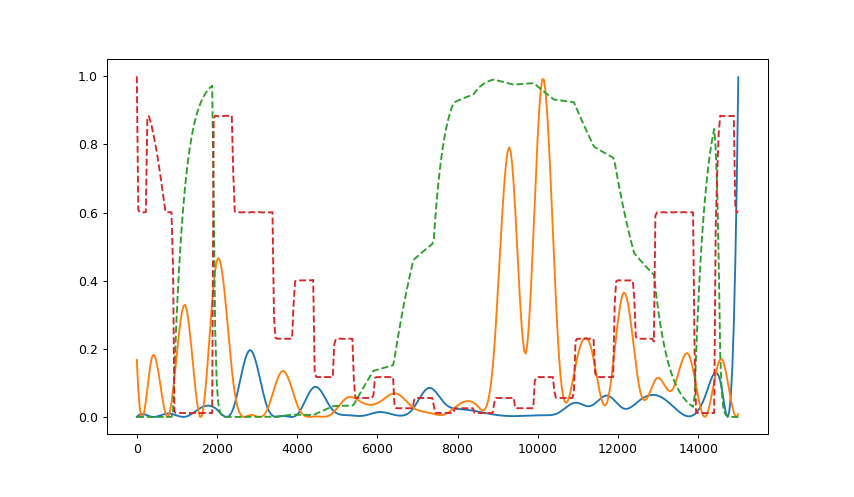

In [124]:
plt.figure()
plt.plot(problem.model.observation_times, problem.get_state(sln['shist'][1]))
plt.plot(problem.model.observation_times,  ar_sol.sol(problem.model.observation_times).T, '--')

<IPython.core.display.Javascript object>


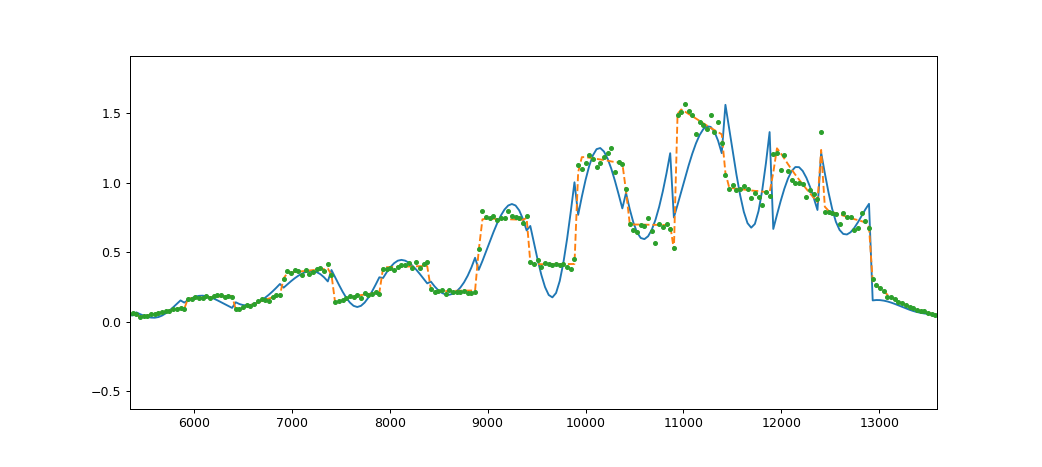

In [134]:
plt.figure()
plt.plot(problem.model.observation_times,
         obsv_ca(problem.model.observation_times, problem.get_state(sln['shist'][0]), problem.get_parameters(sln['shist'][0])))
plt.plot(problem.model.observation_times, truth_synth, '--')
plt.plot(problem.model.observation_times, y_synth, '.')

In [130]:
[problem.get_parameters(x) for x in sln['shist']]

[(DM(61.4589),
  DM(2.34281e-08),
  DM(60.0922),
  DM(2.34296e-08),
  DM(426.634),
  DM(421.857),
  DM(437.912),
  DM(427.313),
  DM(0.0779196)),
 (DM(100.109),
  DM(-4.51853e-16),
  DM(98.2172),
  DM(-4.66006e-16),
  DM(6380.5),
  DM(6314.98),
  DM(6535.06),
  DM(6389.81),
  DM(0.0775622)),
 (DM(100.109),
  DM(0.0157109),
  DM(98.2175),
  DM(0.0157109),
  DM(6380.52),
  DM(6315),
  DM(6535.08),
  DM(6389.83),
  DM(0.0776014)),
 (DM(0.0079593),
  DM(0.0288277),
  DM(0.0213496),
  DM(0.00872655),
  DM(100000),
  DM(100000),
  DM(100000),
  DM(100000),
  DM(0.298308)),
 (DM(5.8752e-05),
  DM(0.00102459),
  DM(2.08742e-05),
  DM(0.0432513),
  DM(100000),
  DM(100000),
  DM(100000),
  DM(100000),
  DM(0.053022)),
 (DM(0.16041),
  DM(0.0205636),
  DM(0.159221),
  DM(0.0100001),
  DM(100000),
  DM(100000),
  DM(100000),
  DM(100000),
  DM(0.0405015))]

In [129]:
p_true

[0.000226,
 0.0699,
 3.45e-05,
 0.05462,
 0.0873,
 0.00891,
 0.00515,
 0.03158,
 0.1524]